<a href="https://colab.research.google.com/github/NiranjanRavi1993/Firmware/blob/master/LSTM_WithRCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import backend
from math import ceil
import keras
import numpy as np
import io 
from google.colab import files 


class TimeseriesGenerator(keras.utils.Sequence):
    """Utility class for generating batches of temporal data.

    This class takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    stride, length of history, etc., to produce batches for
    training/validation.

    # Arguments
        data: Indexable generator (such as list or Numpy array)
            containing consecutive data points (timesteps).
            The data should be at 2D, and axis 0 is expected
            to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`.
        length: Length of the output sequences (in number of timesteps).
        sampling_rate: Period between successive individual timesteps
            `data[i]`, `data[i-r]`, ... `data[i - length]`
            are used for create a sample sequence.
        stride: Period between successive output sequences.
            For stride `s`, consecutive output samples would
            be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
        start_index: Data points earlier than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Data points later than `end_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        reverse: Boolean: if `true`, timesteps in each output sample will be
            in reverse chronological order.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).

    # Returns
        A [Sequence](/utils/#sequence) instance.

    # Examples

    ```python
    from keras.preprocessing.sequence import TimeseriesGenerator
    import numpy as np

    data = np.array([[i] for i in range(50)])
    targets = np.array([[i] for i in range(50)])

    data_gen = TimeseriesGenerator(data, targets,
                                   length=10, sampling_rate=2,
                                   batch_size=2)
    assert len(data_gen) == 20

    batch_0 = data_gen[0]
    x, y = batch_0
    assert np.array_equal(x,
                          np.array([[[0], [2], [4], [6], [8]],
                                    [[1], [3], [5], [7], [9]]]))
    assert np.array_equal(y,
                          np.array([[10], [11]]))
    ```
    """

    def __init__(self, data, targets, length,
                 sampling_rate=1,
                 stride=1,
                 start_index=0,
                 end_index=None,
                 shuffle=False,
                 reverse=False,
                 batch_size=128):
        self.data = data
        self.targets = targets
        self.length = length
        self.sampling_rate = sampling_rate
        self.stride = stride
        self.start_index = start_index + length
        if end_index is None:
            end_index = len(data) - 1
        self.end_index = end_index
        self.shuffle = shuffle
        self.reverse = reverse
        self.batch_size = batch_size

        if self.start_index > self.end_index:
            raise ValueError('`start_index+length=%i > end_index=%i` '
                             'is disallowed, as no part of the sequence '
                             'would be left to be used as current step.'
                             % (self.start_index, self.end_index))

    def __len__(self):
        return (self.end_index - self.start_index +
                self.batch_size * self.stride) // (self.batch_size * self.stride)

    def _empty_batch(self, num_rows):
        samples_shape = [num_rows, self.length // self.sampling_rate]
        samples_shape.extend(self.data.shape[1:])
        targets_shape = [num_rows]
        targets_shape.extend(self.targets.shape[1:])
        return np.empty(samples_shape), np.empty(targets_shape)

    def __getitem__(self, index):
        if self.shuffle:
            rows = np.random.randint(
                self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size *
                                    self.stride, self.end_index + 1), self.stride)
        samples, targets = self._empty_batch(len(rows))
        for j, row in enumerate(rows):
            indices = range(rows[j] - self.length, rows[j], self.sampling_rate)
            samples[j] = self.data[indices]
            targets[j] = self.targets[rows[j]]
        if self.reverse:
            return samples[:, ::-1, ...], targets
        return samples, targets

print(tf.__version__)


df = pd.read_csv('/content/drive/MyDrive/dfresultWithLocalrateMrbdrateCovidValues2020.csv')
df.columns

df = df.drop(['LocalRate', 'morbidtyValues'], axis = 1)
df.head(15)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_AGE65',
       'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG',
       'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ',
       'EP_UNINSUR', 'LST_Day', 'LST_Night', 'NL_Temp', 'NL_Humid ',
       'NL_Pres ', 'NL_windu ', 'NL_Lr ', 'NL_Pe ']] = scaler.fit_transform(df[['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_AGE65',
       'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG',
       'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ',
       'EP_UNINSUR', 'LST_Day', 'LST_Night', 'NL_Temp', 'NL_Humid ',
       'NL_Pres ', 'NL_windu ', 'NL_Lr ', 'NL_Pe ']])
df.head(3150)


#df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
df = df.drop(['FIPS_Final'], axis=1) 
#df = df.drop(['Unnamed: 0'], axis=1)  
print("Done")
print(df.shape) 
#some_values = [18097, 6037]

#df_countySeparated = df.loc[df['Counties'].isin(some_values)]
df_countySeparated = df
df_countySeparated = df_countySeparated[['covidValues', 'EP_POV', 'EP_UNEMP', 'EP_PCI',
       'EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT',
       'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD',
       'EP_NOVEH', 'EP_GROUPQ', 'EP_UNINSUR', 'LST_Day', 'LST_Night',
       'NL_Temp', 'NL_Humid ', 'NL_Pres ', 'NL_windu ', 'NL_Lr ', 'NL_Pe ']]
print(df_countySeparated.columns)


df_countySeparated.columns
print(df_countySeparated.shape)

#DMA
#df_average7Days = df_countySeparated.groupby(np.arange(len(df_countySeparated))//2).mean()
#print(df_average7Days.shape)
#df_countySeparated = df_average7Days
#print(df_countySeparated.shape)

df_countySeparated['covidConfirmedCases_EWM'] = df['covidValues'].ewm(span=48, adjust=False).mean()
#df_countySeparated['covidConfirmedCases_EWM'] = df['CovidValues']
df_countySeparated = df_countySeparated[['covidConfirmedCases_EWM', 'EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_AGE65',
       'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG',
       'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ',
       'EP_UNINSUR', 'LST_Day', 'LST_Night', 'NL_Temp', 'NL_Humid ',
       'NL_Pres ', 'NL_windu ', 'NL_Lr ', 'NL_Pe ']]
df_countySeparated.columns

data_scaled = scaler.fit_transform(df_countySeparated)
data_scaled

features = data_scaled
target = data_scaled[:, 0]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 1, shuffle = False)
x_train.shape
x_test.shape
batch_size = 128
win_length = 7
num_features = 27

train_generator = TimeseriesGenerator(x_train, y_train, length = win_length, sampling_rate=1, batch_size=batch_size)
test_generator =  TimeseriesGenerator(x_test,  y_test,   length = win_length, sampling_rate=1, batch_size=batch_size)

print(train_generator[0][0].shape)
print("DoneTillHere")
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), 
    return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.LSTM(64, return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(32, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
"""
model.add(tf.keras.layers.LSTM(256, input_shape=(win_length, num_features), 
    return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.LSTM(64, return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(32, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
"""

2.4.1
Done
(34188, 25)
Index(['covidValues', 'EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP', 'EP_AGE65',
       'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG',
       'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ',
       'EP_UNINSUR', 'LST_Day', 'LST_Night', 'NL_Temp', 'NL_Humid ',
       'NL_Pres ', 'NL_windu ', 'NL_Lr ', 'NL_Pe '],
      dtype='object')
(34188, 25)
(128, 7, 25)
DoneTillHere


'\nmodel.add(tf.keras.layers.LSTM(256, input_shape=(win_length, num_features), \n    return_sequences=True))\nmodel.add(tf.keras.layers.LeakyReLU(alpha = 0.5))\nmodel.add(tf.keras.layers.LSTM(128, return_sequences = True))\nmodel.add(tf.keras.layers.LeakyReLU(alpha = 0.5))\nmodel.add(tf.keras.layers.LSTM(64, return_sequences = True))\nmodel.add(tf.keras.layers.LeakyReLU(alpha = 0.5))\nmodel.add(tf.keras.layers.Dropout(0.3))\nmodel.add(tf.keras.layers.LSTM(32, return_sequences = False))\nmodel.add(tf.keras.layers.Dropout(0.3))\nmodel.add(tf.keras.layers.Dense(1))\n'

In [2]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 16.1MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15, mode='min')
model.compile(loss='mean_squared_error', optimizer = 'Adamax', metrics = ['mean_absolute_error'])
history = model.fit(train_generator, epochs=3, 
                              validation_data = test_generator,
                              shuffle=False)
#print(history.history.keys())


Epoch 1/3
187/187 [==============================] - 12s 15ms/step - loss: 3.6965e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0098 - val_mean_absolute_error: 0.0553
Epoch 2/3
187/187 [==============================] - 2s 11ms/step - loss: 6.0540e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0099 - val_mean_absolute_error: 0.0562
Epoch 3/3
187/187 [==============================] - 2s 10ms/step - loss: 5.3934e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0095 - val_mean_absolute_error: 0.0558


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<bound method DataFrame.count of        covidConfirmedCases_EWM    EP_POV  ...    NL_Lr     NL_Pe 
23938             31300.316779  0.957974  ...  0.434966  0.475689
23939             30268.589564  0.963096  ...  0.548965  0.526659
23940             29040.524684  0.957879  ...  0.554533  0.520687
23941             27865.442043  0.961579  ...  0.427377  0.462667
23942             26742.770940  0.963476  ...  0.429944  0.463448
...                        ...       ...  ...       ...       ...
34183            128984.573903  0.959112  ...  0.135771  0.040045
34184            126161.938233  0.954464  ...  0.134808  0.090141
34185            122720.512183  0.959586  ...  0.139878  0.020760
34186            118533.225971  0.959492  ...  0.197327  0.025417
34187            114252.522870  0.964235  ...  0.231130  0.033368

[10250 rows x 25 columns]>
Accuracy: -0.13283410283804753


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


'\nfrom google.colab import files\nfiles.download(\'rporgramLSTMResult.csv\')\n\ndf_final.to_csv("rporgramLSTMResult.csv")\n\n'

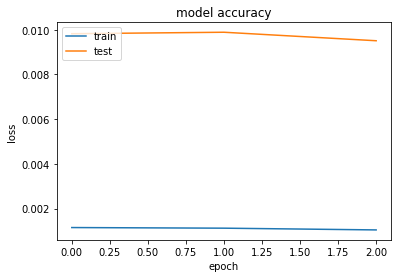

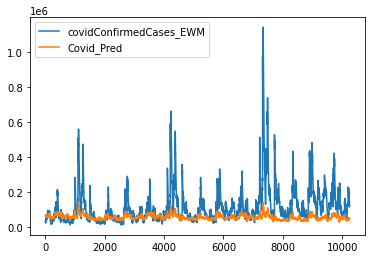

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

model.evaluate_generator(test_generator, verbose=0 )
predictions = model.predict_generator(test_generator)
predictions.shape[0]
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:, 1:][win_length:])], axis = 1)
rev_trans = scaler.inverse_transform(df_pred)
df_final = df_countySeparated[predictions.shape[0]*-1:]
print(df_final.count)
df_final['Covid_Pred'] = rev_trans[:, 0]
df_final
df_final.reset_index(drop=True, inplace=True)
df_final[['covidConfirmedCases_EWM','Covid_Pred']].plot()


y_test = df_final.loc[:,'covidConfirmedCases_EWM']
y_pred = df_final.loc[:,'Covid_Pred']

from sklearn.metrics import r2_score
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",r2_score(y_test, y_pred))


"""
from google.colab import files
files.download('rporgramLSTMResult.csv')

df_final.to_csv("rporgramLSTMResult.csv")

"""


In [6]:
!pip install shap

     |████████████████████████████████| 358kB 16.1MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489392 sha256=499eae3d991e0cf0f6efdee474d4c6fd8db1fc4c81afbe094353ab0147e3f4a6
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [7]:
import shap

In [8]:
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output),train_generator)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


AttributeError: ignored

In [10]:
print(shap.__version__)

0.38.1
